# Эксперименты с цифрами

## Подготовка

In [1]:
# Подключаем библиотеки
import os
os.chdir("..")

from compiled_wrapper import scidi_wrapper

import pandas
import numpy as np
import json
import random
import time 
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Загружаем данные с одинарным шумом
data = pandas.read_csv('test_data/numbers/digits+noise.csv', header=None)
data = data[data.columns[:-1]]
# Преобразуем в строку (оболочка работает пока только со строковым представлением)
str_data = data.values.astype(str)
print str_data[:5]

[['6' '2' '2' '7' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1' '1' '3' '5' '8'
  '1' '3' '7' '4' '4' '6']
 ['6' '2' '2' '7' '5' '1' '1' '8' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '4' '4' '6']
 ['6' '2' '2' '7' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '8' '4' '6']
 ['6' '2' '2' '7' '5' '1' '1' '3' '8' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '4' '4' '6']
 ['6' '2' '8' '7' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '4' '4' '6']]


Посмотрим, как выглядят наши цифры

In [3]:
# Функция для визуализации

features = [[[0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],],
            [[1, 1, 1, 1, 1],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],],
            [[0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],],
            [[0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [1, 1, 1, 1, 1],],
            [[1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],],
            [[0, 0, 0, 0, 1],
             [0, 0, 0, 1, 0],
             [0, 0, 1, 0, 0],
             [0, 1, 0, 0, 0],
             [1, 0, 0, 0, 0],],
            [[1, 0, 0, 0, 0],
             [0, 1, 0, 0, 0],
             [0, 0, 1, 0, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1],],
            [[1, 0, 1, 0, 1],
             [0, 1, 0, 1, 0],
             [1, 0, 1, 0, 1],
             [0, 1, 0, 1, 0],
             [1, 0, 1, 0, 1],],
            [[-1, 0, -1, 0, -1],
             [0, -1, 0, -1, 0],
             [-1, 0, -1, 0, -1],
             [0, -1, 0, -1, 0],
             [-1, 0, -1, 0, -1],]]

def getVisualizationMatrix(obj):
    obj_img = np.empty((0,20))
    for i in range(6):
        current_raw = np.empty((5,0))
        for j in range(4):
            current_raw = np.concatenate((current_raw, np.array(features[int(obj[i*4 + j]) - 1])), axis = 1)
        obj_img = np.concatenate((obj_img, current_raw), axis = 0)
    return obj_img 
            

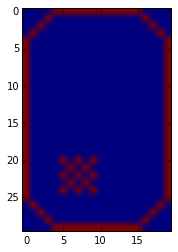

In [4]:
plt.imshow(getVisualizationMatrix(str_data[0]))
plt.show()

In [5]:
# Вспомогательная функция для генерации подвыборки и шума

def make_sample_with_noise_elements(data, sample_size = -1, noise_elements_count = 0):
    if sample_size >= 0:
        inds = np.random.choice(range(len(data)), sample_size)
        sample = data[inds]
    else:
        sample = data
    
    noise_data = []
    
    for j in range(noise_elements_count):
        current_element = []
        for i in range(data.shape[1]):    
            current_element.append(str(random.randint(1, 8)))
        noise_data.append(current_element)
    
    noise_data = np.array(noise_data)
    
    if noise_elements_count > 0:
        sample_with_noise = np.concatenate((sample, noise_data))
        return sample_with_noise
    
    return sample

In [6]:
# Видимо правила хорошо усваиваются системой только в лексикографическом порядке...
def ruleToPredAndVal(rule):
    preds = rule.split()
    preds = filter(lambda x : '=' in x and not '>' in x, preds)
    preds = preds[-1:] + preds[:-1]
    preds = [p.split('=') for p in preds]
    pred_pos = [int(p[0]) for p in preds]
    pred_vals = tuple([int(p[1]) for p in preds])
    pred_pos.insert(1, pred_vals[0])
    return tuple(pred_pos), pred_vals


In [7]:
# Вспомогательная функция для обработки естественных классов
def mapToNoNoise(item):
    item = item [1:]

    item = [int(i) for i in item]
    if len(item) > 0:
        return min(item)
    return 0
    

In [8]:
sw = scidi_wrapper.ScidiWrapper()

In [9]:
noised_data = make_sample_with_noise_elements(str_data, noise_elements_count = 1000)

In [10]:
sw.setData(noised_data)
sw.makeRulesWithSDGenerator(3, 0.2, 1, 0.95)
rules = sw.getRules()
print len(rules)


2451416


In [11]:
sorted_rules = sorted(rules, key=lambda x: ruleToPredAndVal(x)[1])
sorted_rules = sorted(sorted_rules, key=lambda x: ruleToPredAndVal(x)[0])

In [17]:
# Случайные подмножества правил!

sorted_rules = np.array(sorted_rules)
rules_subset_idx = np.random.choice(range(sorted_rules.shape[0]), 200000, replace=False)
rules_subset_idx.sort()
print sorted_rules[rules_subset_idx][:5]

['2=5 & 3=2 & 4=4 => 1=1' '2=8 & 3=3 & 4=4 => 1=1' '2=8 & 3=7 & 4=8 => 1=1'
 '2=3 & 3=3 & 5=5 => 1=1' '2=7 & 3=6 & 5=6 => 1=1']


In [18]:
sw.setData(str_data)

In [19]:
sw.setRulesFromStringVector(sorted_rules[rules_subset_idx])

In [15]:
sw.makeClasses()

In [16]:
# Получим все естественные класссы
denoised_classes = map(lambda z: tuple(map(lambda x: mapToNoNoise(x), z)), sw.getIdealObjects())

# Число естественных классов
print len(set(denoised_classes))

class_ids = sw.getClasses()

108


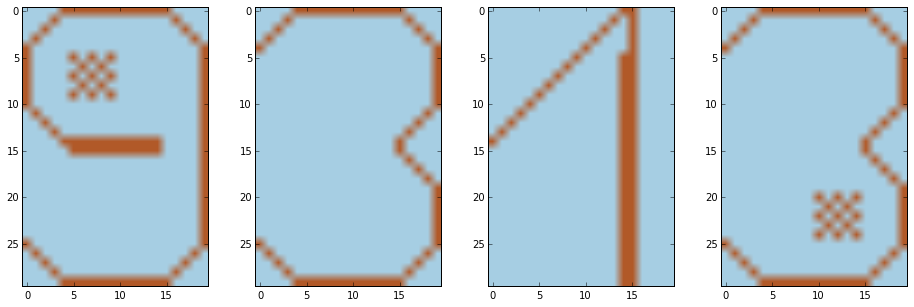

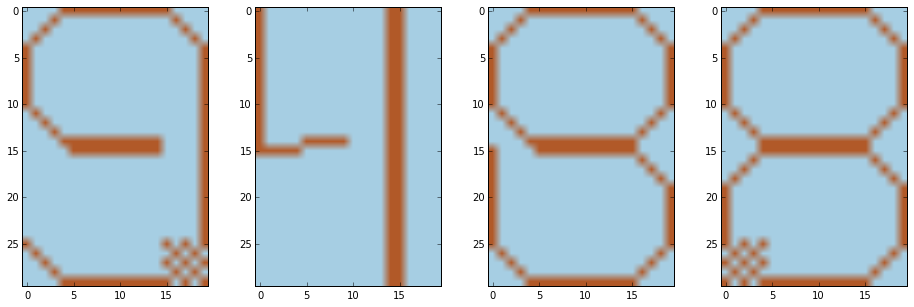

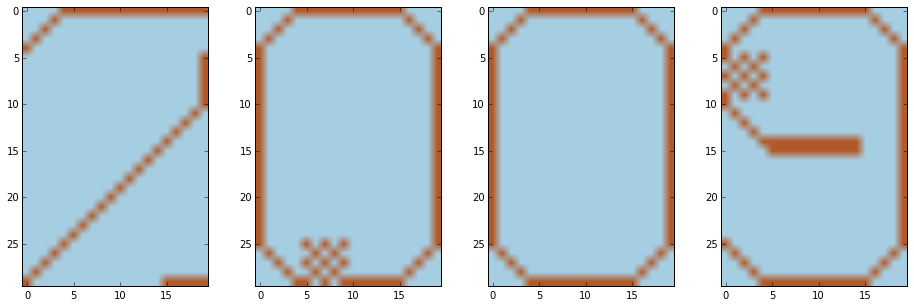

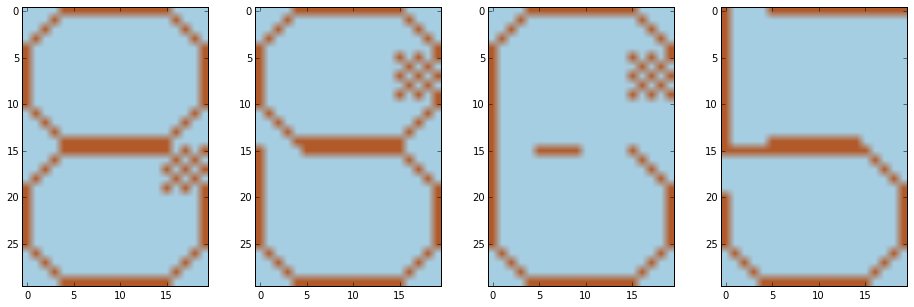

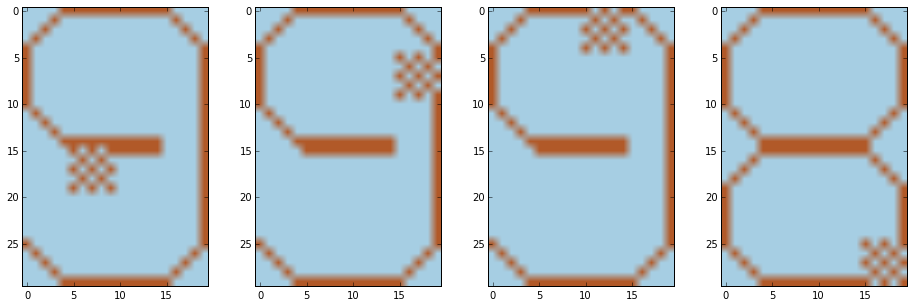

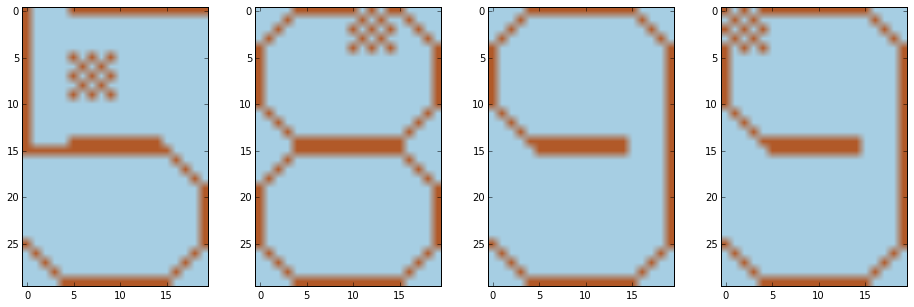

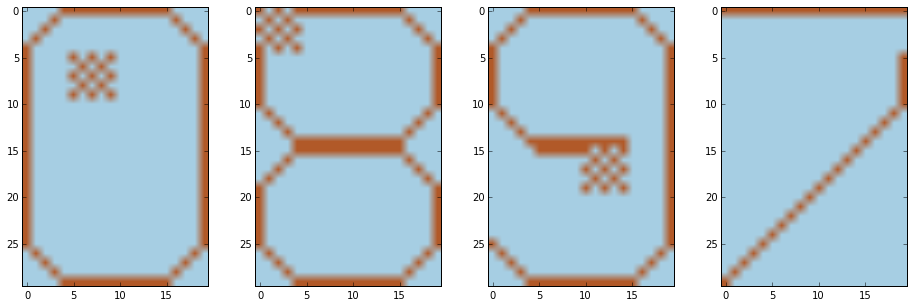

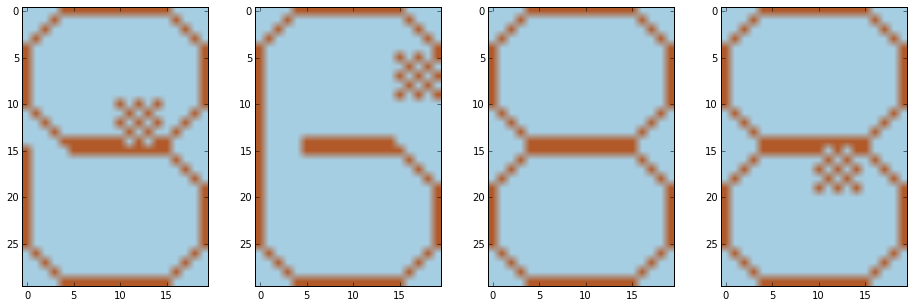

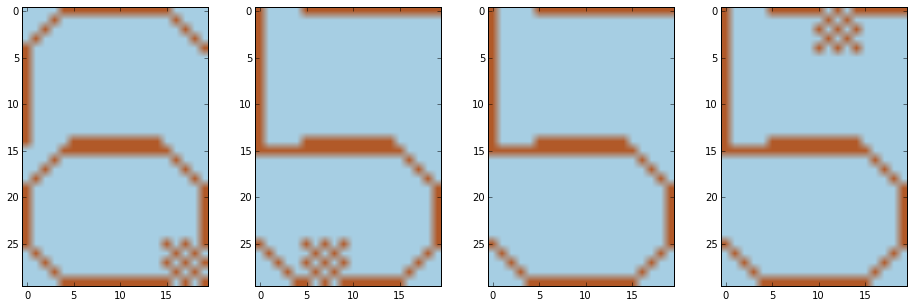

In [108]:
# Выведем получившиеся классы:

from matplotlib import cm
unique_classes = list(set(denoised_classes))

width =  4
height = int ((len(unique_classes) * 1.0 - 1) / width) + 1 

for j in range(0, height):
    plt.figure(figsize = (16, 5))
    for i in range(width):
        if i + width * j >= len(unique_classes):
            break
        img = getVisualizationMatrix(unique_classes[i + width * j])
        plt.subplot(1, width, i + 1)
        plt.imshow(img, cmap = cm.Paired)
    
    plt.show()

## Эксперимент с одинарным пропуском

In [29]:
# Загрузим правила. Данные правила были получены на объектах с пропусками и шумом
f = open("rules_d2.txt", 'r')
rules = f.readlines()
f.close()

rules = map(lambda x: x[:-1], rules)
rules[-10:]

['22=4 & 24= not 4 => 24=6',
 '22=4 & 24= not 4 & 24= not 8 => 24=6',
 '23= not 3 => 24=6',
 '23= not 3 & 24= not 4 => 24=6',
 '23=4 & 24= not 4 => 24=6',
 '23=4 & 24= not 4 & 24= not 8 => 24=6',
 '24= not 4 => 24=6',
 '24= not 4 & 24= not 5 => 24=6',
 '24= not 4 & 24= not 5 & 24= not 8 => 24=6',
 '24= not 5 => 24=6']

In [30]:
len(rules)
rules = np.array(rules)

In [31]:
idx = np.random.choice(range(len(rules)), 1000)

In [32]:
# list(rules[idx])

In [20]:
# Загружаем данные и правила в естественную классификацию
sw.setData(str_data)
sw.setRulesFromStringVector(list(rules[idx]))

In [ ]:
# Создаем естественные классы объектов
sw.makeClasses()

In [34]:
# Получим все естественные класссы
denoised_classes = map(lambda z: tuple(map(lambda x: mapToNoNoise(x), z)), sw.getIdealObjects())

# Число естественных классов
print len(set(denoised_classes))

class_ids = sw.getClasses()

184


In [35]:
# Число естественных классов
len(set(denoised_classes))

184

In [36]:
len(class_ids)

360

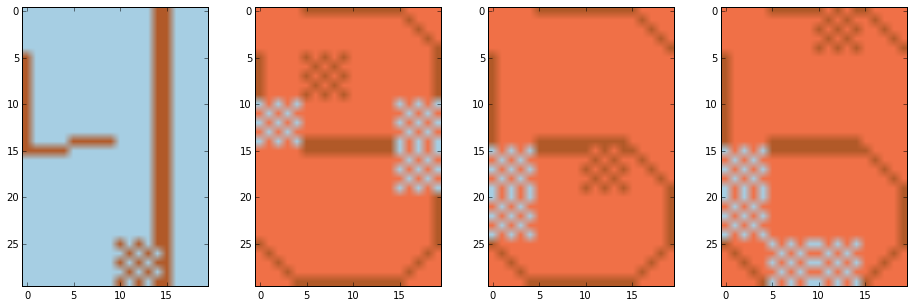

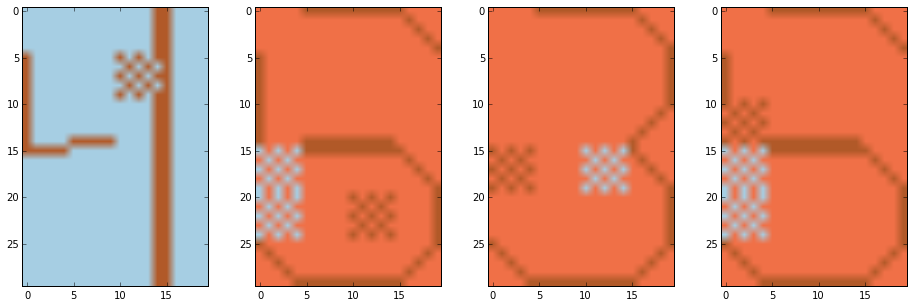

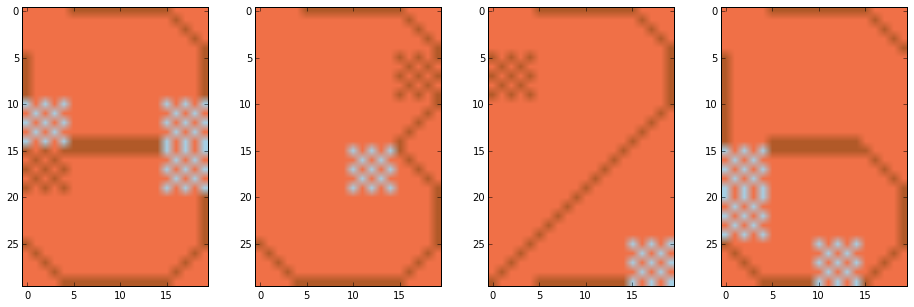

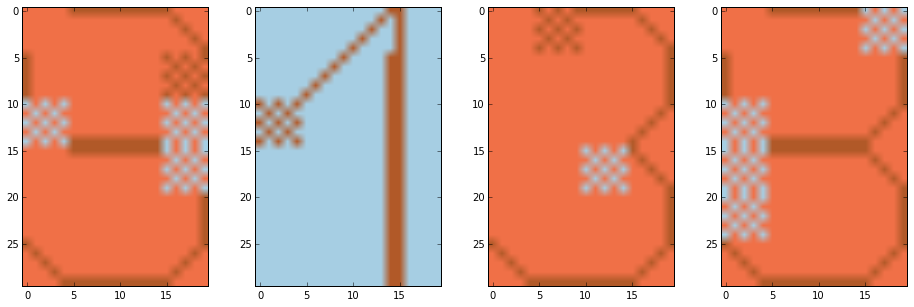

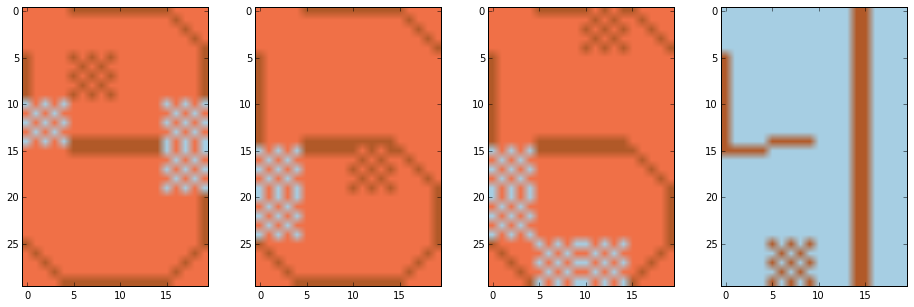

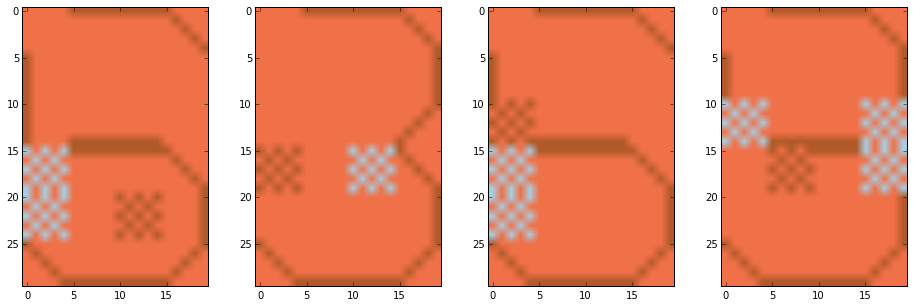

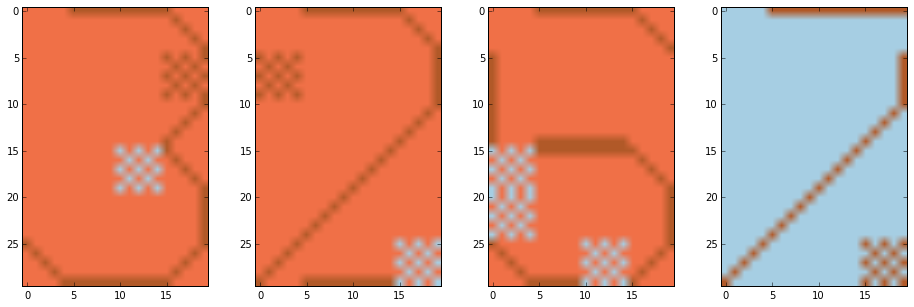

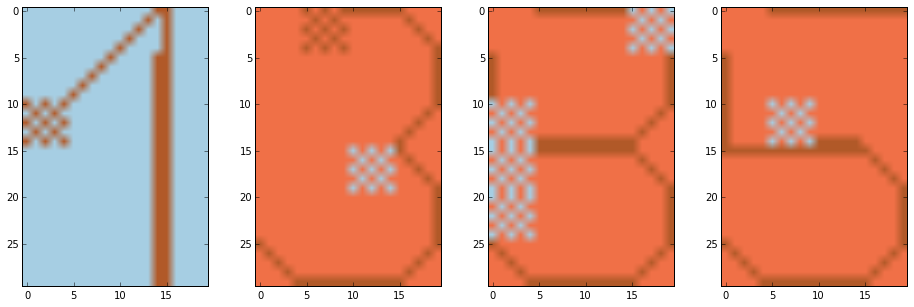

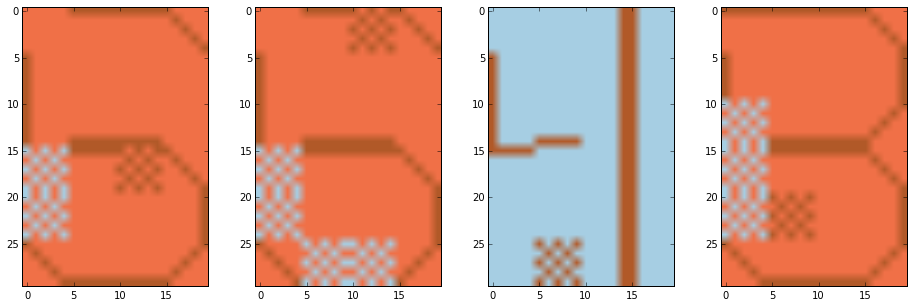

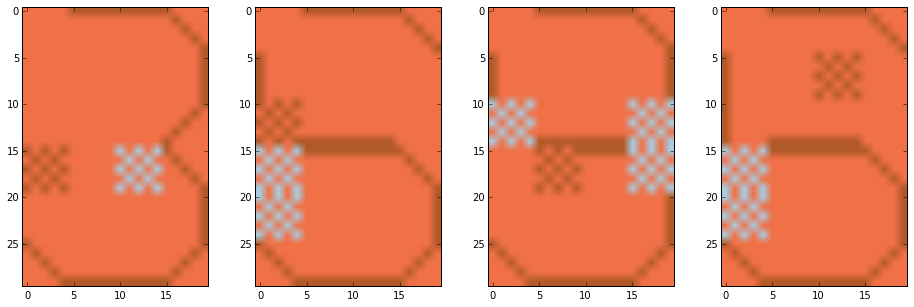

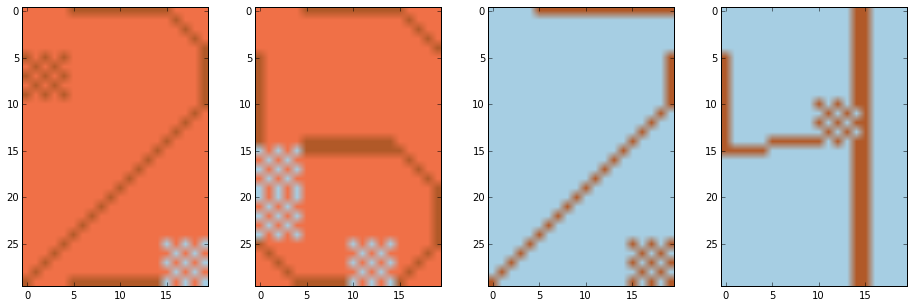

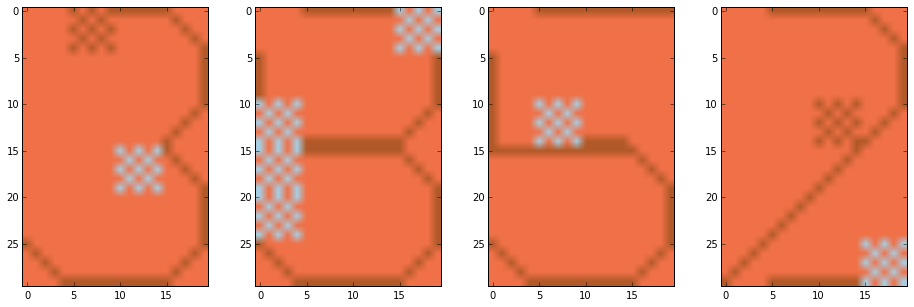

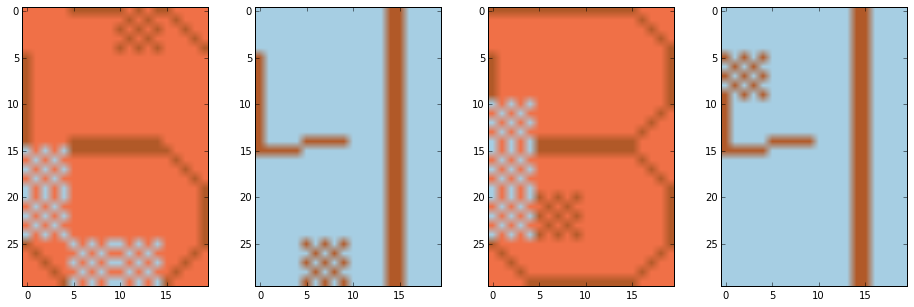

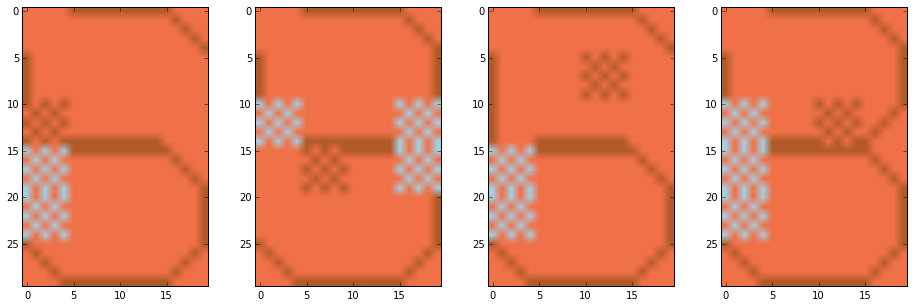

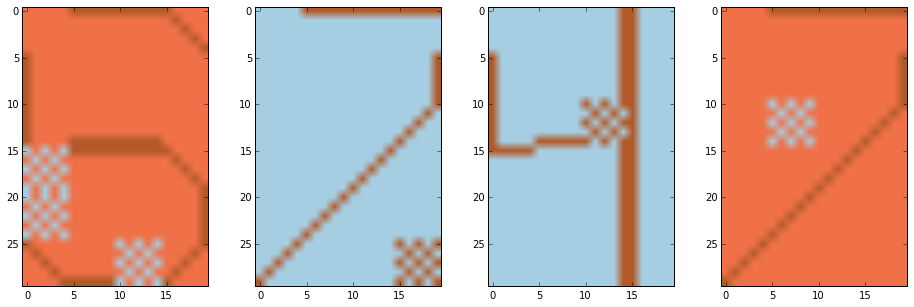

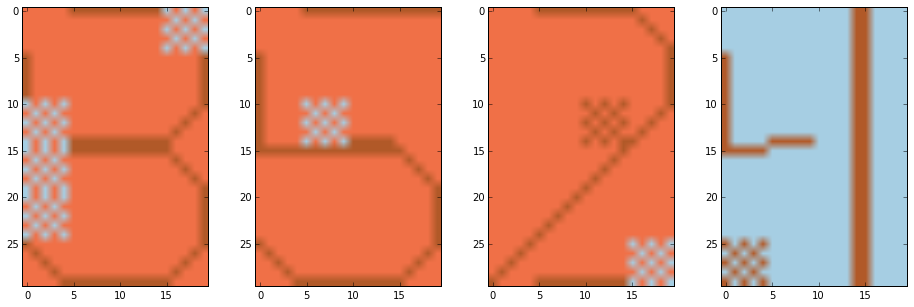

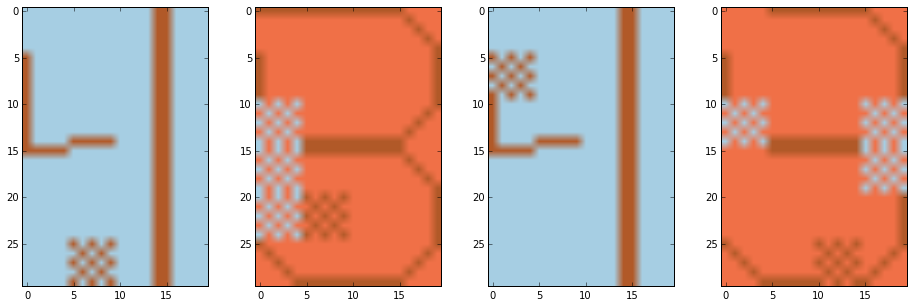

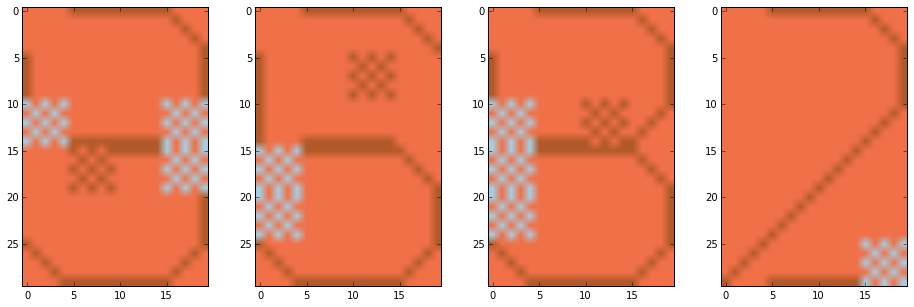

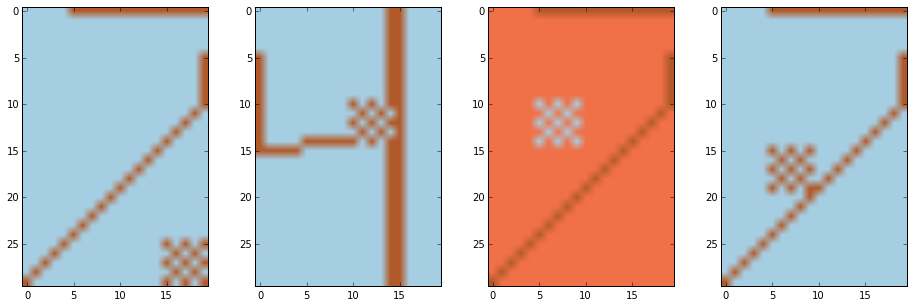

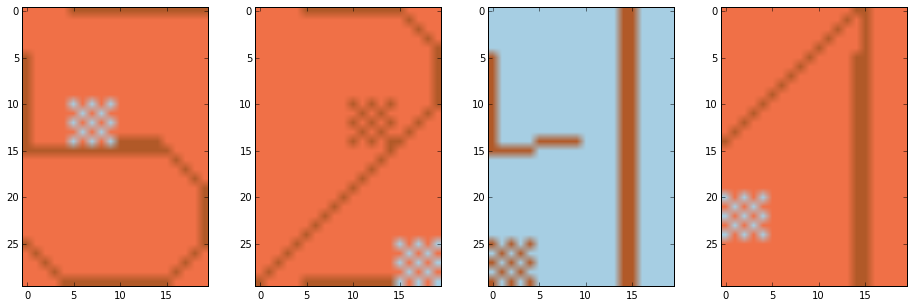

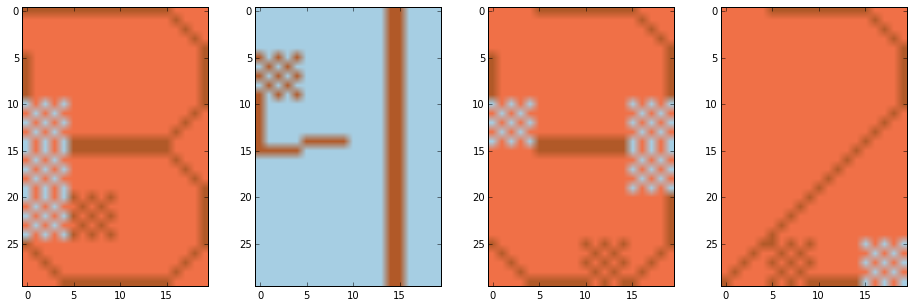

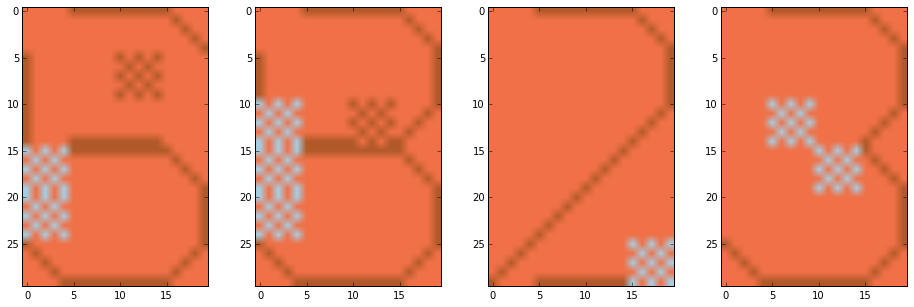

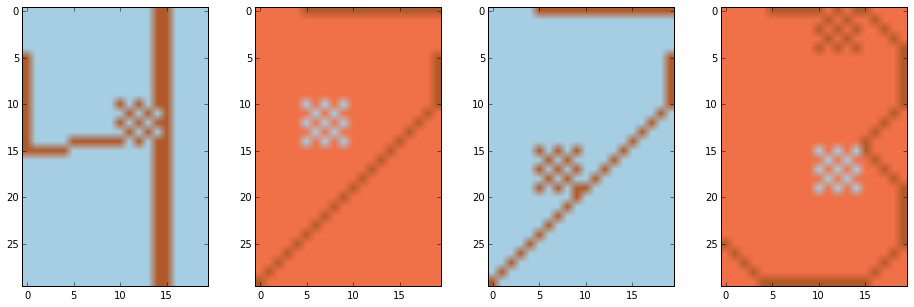

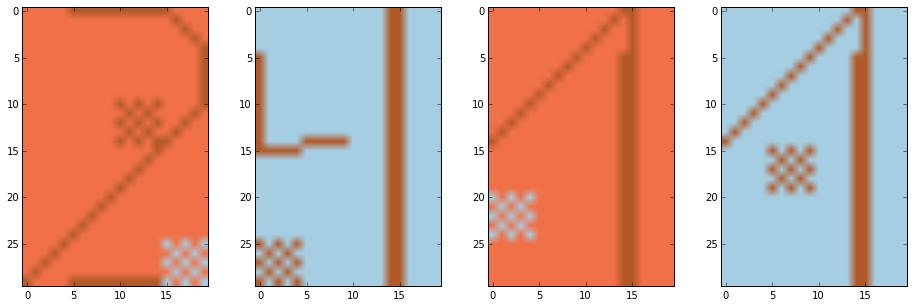

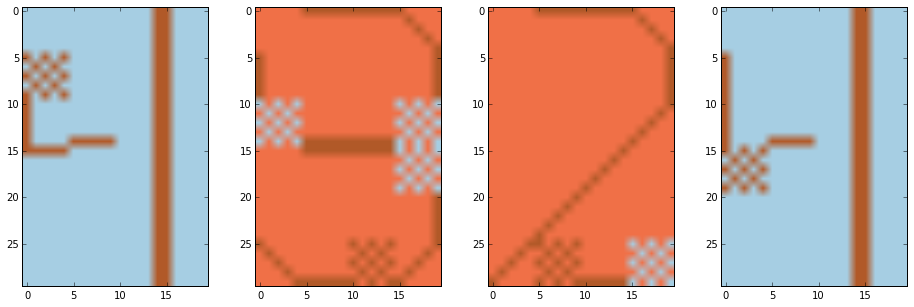

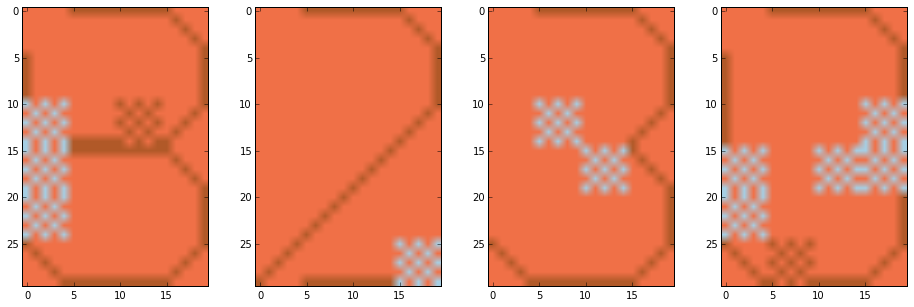

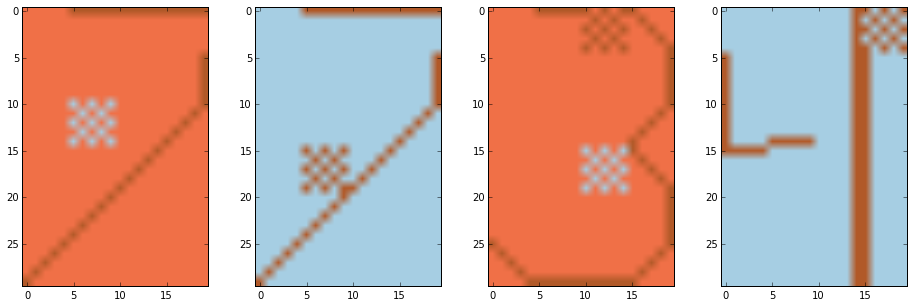

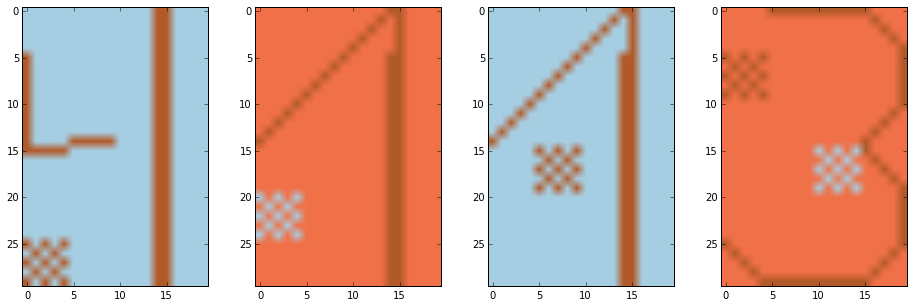

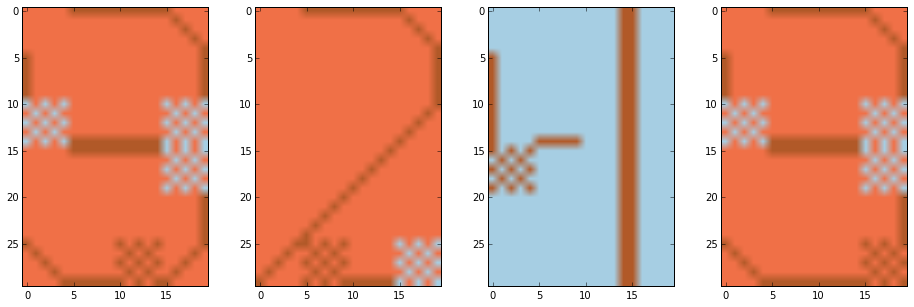

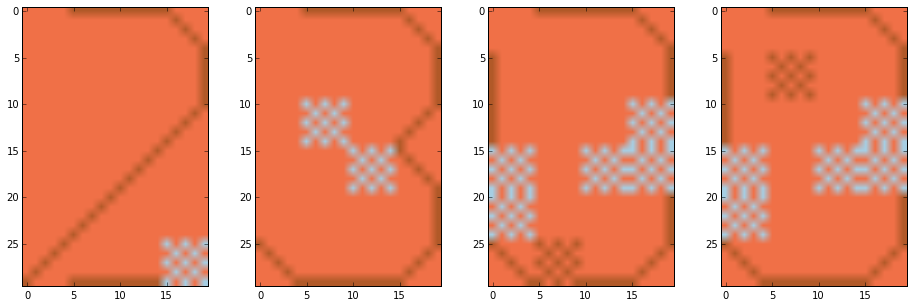

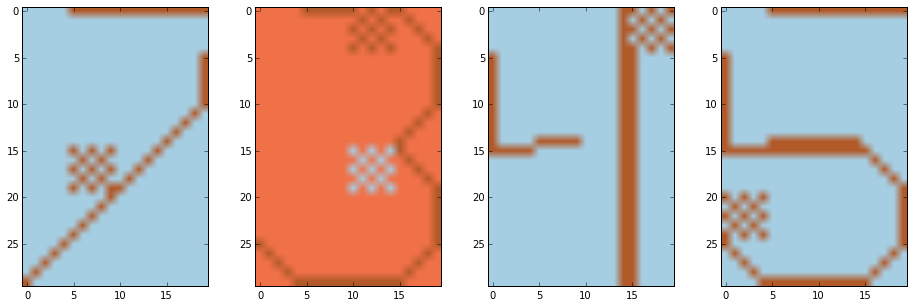

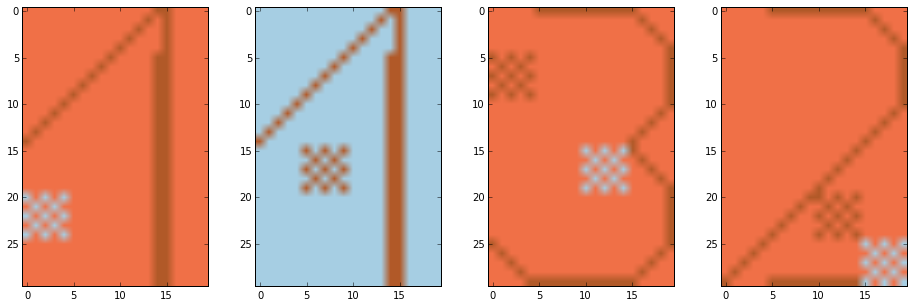

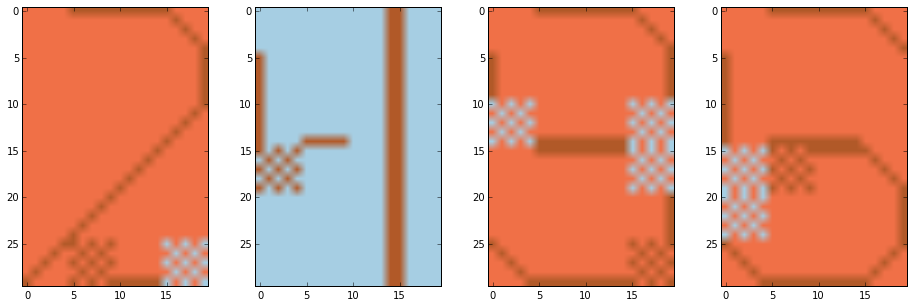

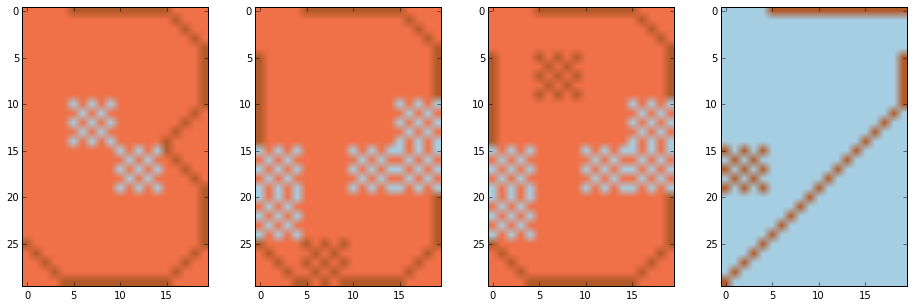

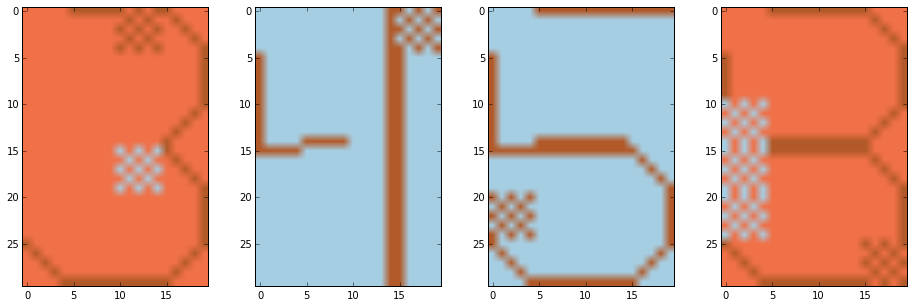

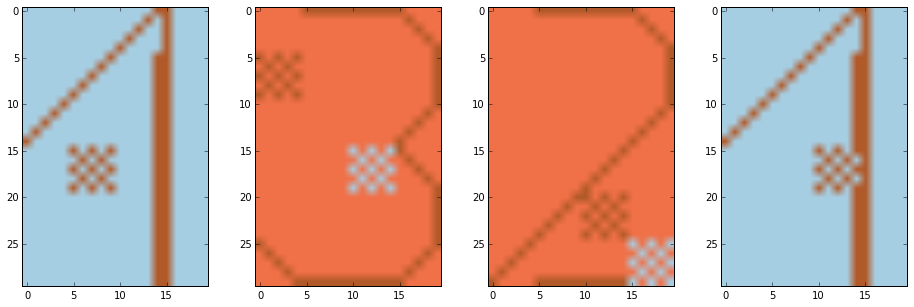

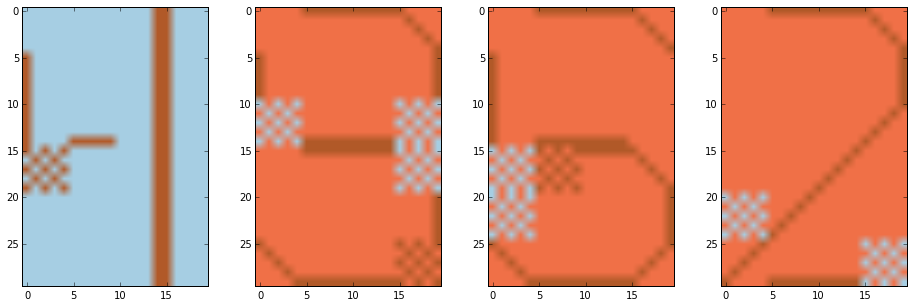

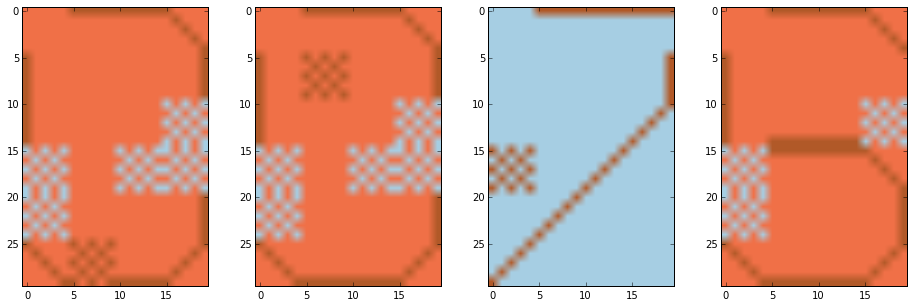

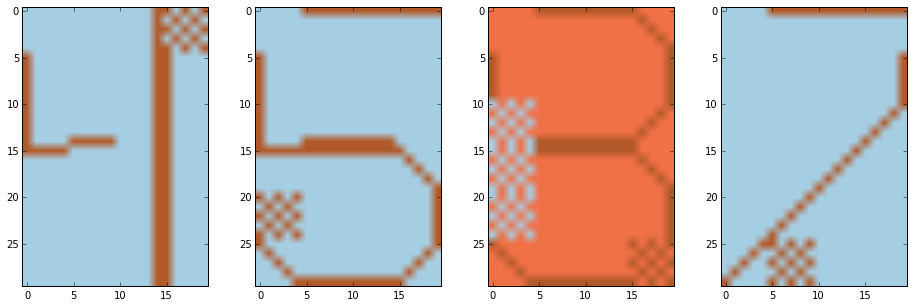

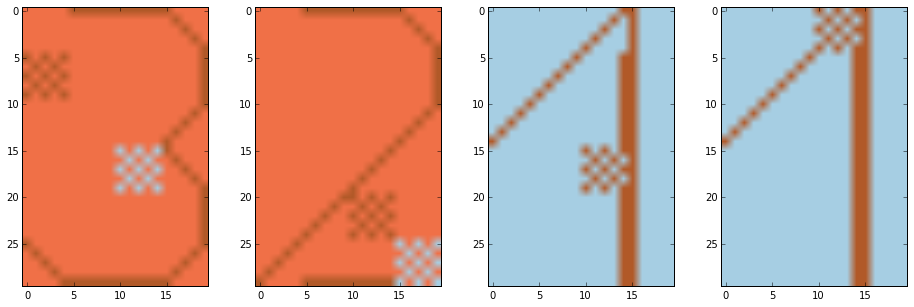

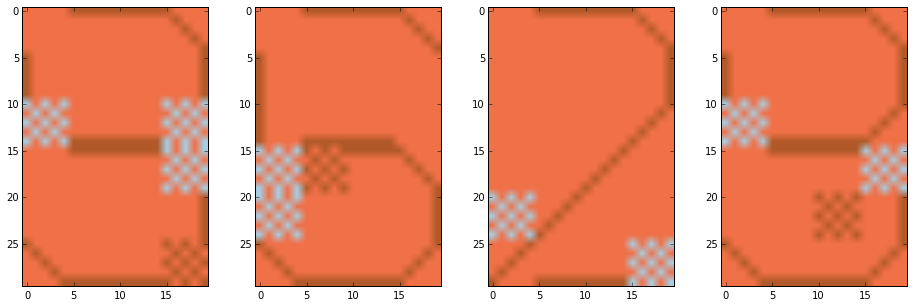

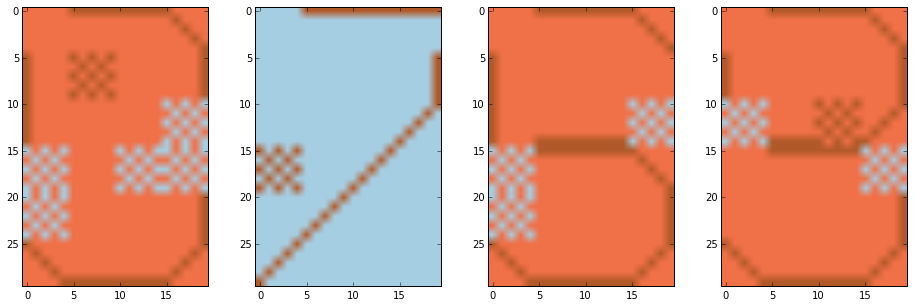

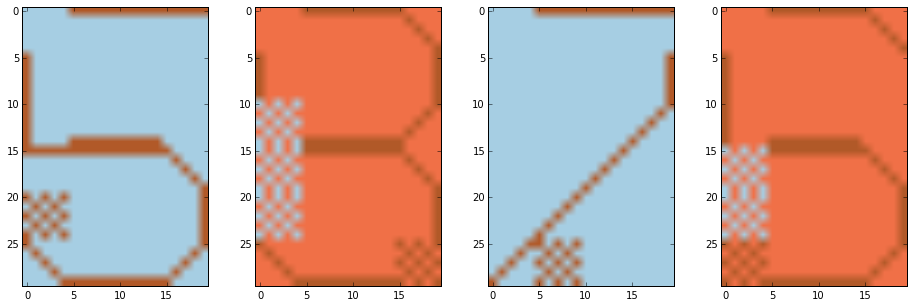

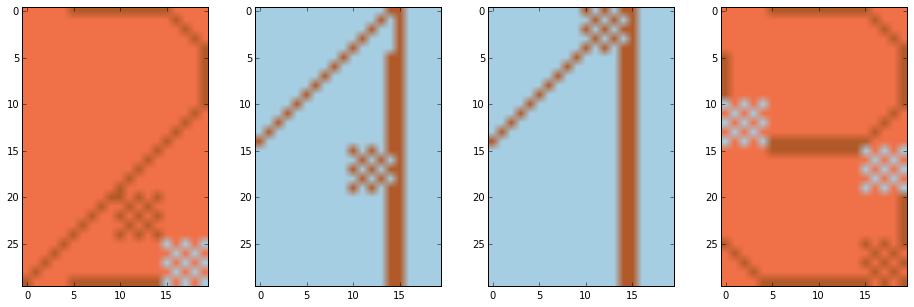

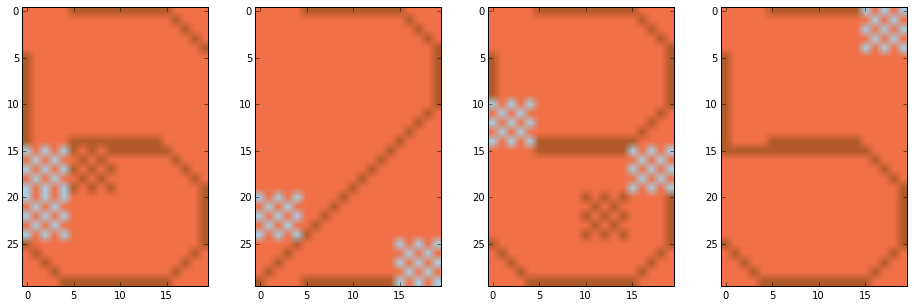

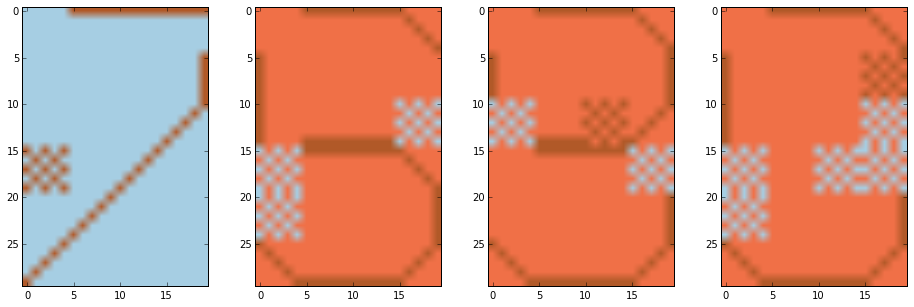

In [37]:
# Выведем получившиеся классы:

from matplotlib import cm
unique_classes = list(set(denoised_classes))

width =  4
height = int ((len(unique_classes) * 1.0) / width)

for j in range(1, height + 1):
    plt.figure(figsize = (16, 5))
    for i in range(width):
        if i * j >= len(unique_classes):
            break
        
        img = getVisualizationMatrix(unique_classes[i*width + j - 1])
        plt.subplot(1, width, i + 1)
        plt.imshow(img, cmap = cm.Paired)
    
    plt.show()


In [16]:
# Выведем соответствия класс - объект:
def plotObjVersusIdeal(str_data, class_ids, denoised_classes):
    width =  4
    height = len(class_ids) / width


    plt.figure(figsize = (14, height * 7))
    for i in range(height * 2):
        for j in range(1, width + 1):
            if (i*width + j - 1) / 2 >= len(str_data):
                break

            if (j % 2  == 1):
                img_orig = getVisualizationMatrix(str_data[(i*width + j - 1) / 2])
                plt.subplot(height * 2, width, (i*width + j))

                plt.title("original {0}".format((i*width + j - 1) / 2))
                plt.imshow(img_orig, cmap = cm.Paired)


            else:
                img = getVisualizationMatrix(denoised_classes[class_ids[(i*width + j - 1) / 2]])
                plt.subplot(height * 2, width, (i*width + j))
                plt.title("ideal {0}".format((i*width + j - 1) / 2))
                plt.imshow(img, cmap = cm.Paired)


    plt.show()


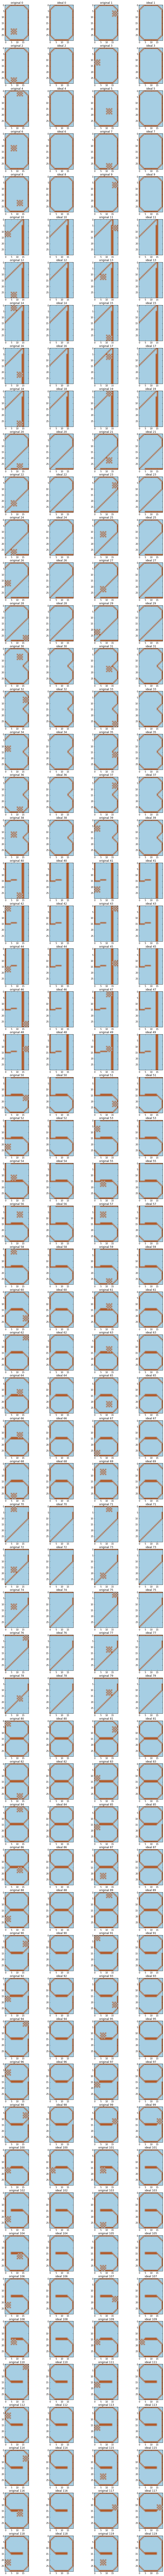

In [16]:
plotObjVersusIdeal(str_data[: 120], class_ids[:120], denoised_classes)


## 2. Double miss

In [17]:
def addRandomHole(data):
    success = False
    while not success:
        pos = random.randint(0, len(data) - 1)
        if data[pos] != '8':
            success = True
            data[pos] = '8'
    return data
        

In [18]:
str_data_double_noise = map(addRandomHole, str_data)

In [19]:
sw.setData(str_data_double_noise)
sw.makeClasses()

In [20]:
# Получим все естественные класссы
denoised_classes_2 = map(lambda z: tuple(map(lambda x: mapToNoNoise(x), z)), sw.getIdealObjects())

# Число естественных классов
print len(set(denoised_classes_2))

class_ids_2 = sw.getClasses()

17


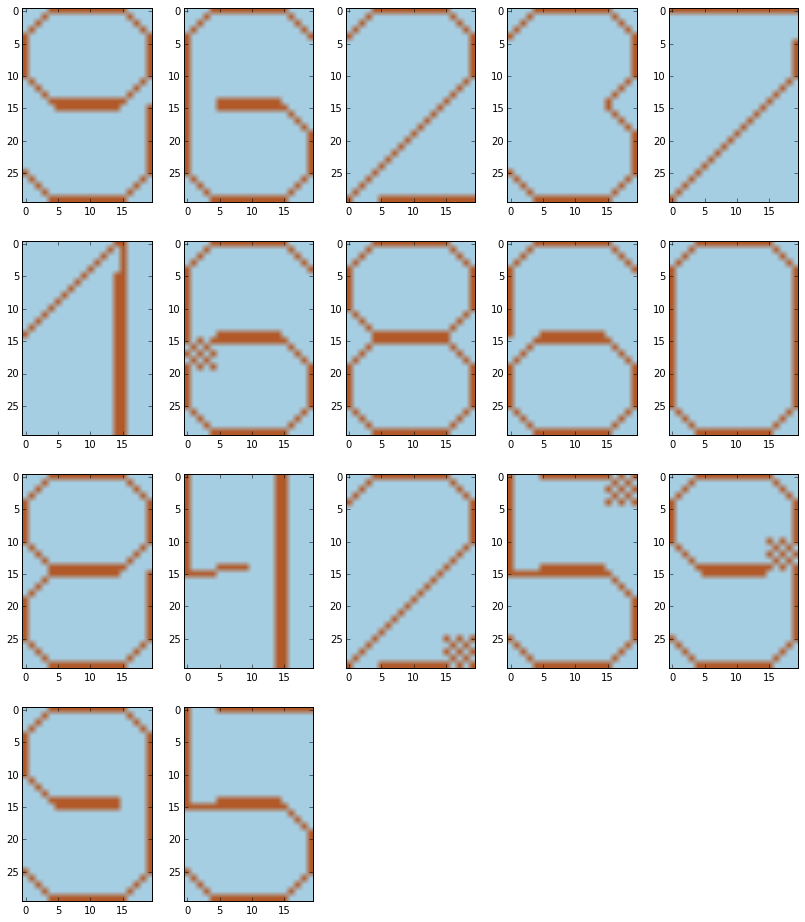

In [23]:
# Выведем получившиеся классы:

from matplotlib import cm
unique_classes = list(set(denoised_classes_2))

width =  4
height = int ((len(unique_classes) * 1.0) / width + 1)

plt.figure(figsize = (14, 16))
for i in range(width):
    for j in range(1, height + 1):
        if i * j >= len(unique_classes):
            break
        
        img = getVisualizationMatrix(unique_classes[i*width + j - 1])
        plt.subplot(width, height, i*width + j)
        plt.imshow(img, cmap = cm.Paired)
    
plt.show()

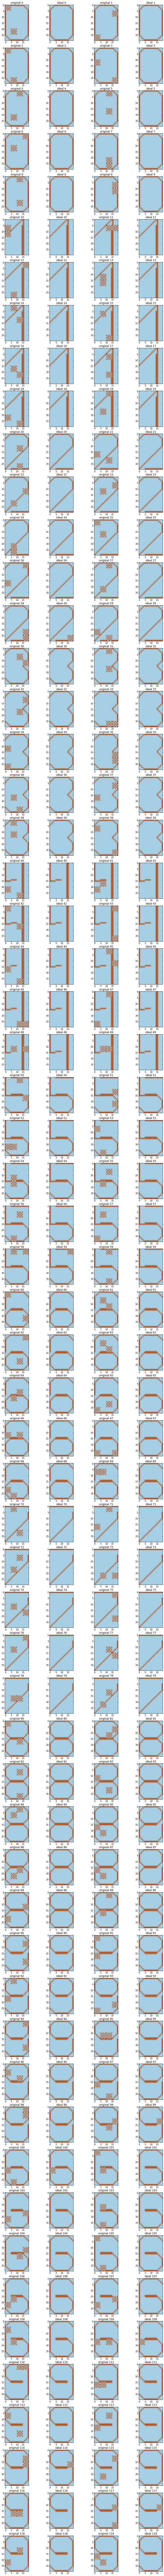

In [22]:
# Выведем соответствия класс - объект:
plotObjVersusIdeal(str_data_double_noise[: 120], class_ids_2[:120], denoised_classes_2)